In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv(r'C:\Users\Maintenant prêt\Desktop\STOCK\Data\baba_long_data.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400
1,2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800
2,2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800
3,2014-09-24,87.467667,87.467667,84.232417,85.439600,32088000
4,2014-09-25,85.874191,88.365819,85.468579,87.969860,28598000
...,...,...,...,...,...,...
2601,2025-01-23,86.099998,86.199997,84.959999,85.800003,9225600
2602,2025-01-24,89.139999,89.190002,86.480003,86.709999,18791000
2603,2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800
2604,2025-01-28,96.029999,96.430000,89.900002,90.940002,31296300


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400
2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800
2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800
2014-09-24,87.467667,87.467667,84.232417,85.439600,32088000
2014-09-25,85.874191,88.365819,85.468579,87.969860,28598000
...,...,...,...,...,...
2025-01-23,86.099998,86.199997,84.959999,85.800003,9225600
2025-01-24,89.139999,89.190002,86.480003,86.709999,18791000
2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800


In [6]:
# check the frequency
print(data.index.freq)

None


In [7]:
# Set the frequency to daily
data = data.resample('D').ffill()

In [8]:
print(data.index.freq)

<Day>


In [9]:
# check for missing
data.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## Stationarity Check

In [10]:
# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.4253815469523197
p-value: 0.5700492279846168
Critical Values:
   1%: -3.4320926833394925
   5%: -2.86231002141224
   10%: -2.5671798929611827
The data is non-stationary (fail to reject the null hypothesis).


In [11]:
# Apply differencing
data['Close_diff'] = data['Close'].diff().dropna()

In [12]:
data

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400,NaN
2014-09-20,90.673950,96.284936,86.868906,89.524709,271879400,0.000000
2014-09-21,90.673950,96.284936,86.868906,89.524709,271879400,0.000000
2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800,-3.862984
2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800,-2.626839
...,...,...,...,...,...,...
2025-01-25,89.139999,89.190002,86.480003,86.709999,18791000,0.000000
2025-01-26,89.139999,89.190002,86.480003,86.709999,18791000,0.000000
2025-01-27,89.989998,91.430000,89.220001,90.589996,25999800,0.849998


In [13]:
# drop Na from close_diff
data.dropna(inplace=True)

In [14]:
# Use only the 'Close_diff' column
data = data[['Close_diff']]

In [15]:
data

,Close_diff
Date,
2014-09-20,0.000000
2014-09-21,0.000000
2014-09-22,-3.862984
2014-09-23,-2.626839
2014-09-24,3.283539
...,...
2025-01-25,0.000000
2025-01-26,0.000000
2025-01-27,0.849998


## Train-Test split

In [16]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Models

## ARIMA

# Fit ARIMA Model:

In [17]:
model = ARIMA(train['Close_diff'], order=(2, 1, 0))
fitted_model = model.fit()

# Forecaast and Evaluate

In [18]:
# Generate forecasts using the fitted ARIMA model
arima_forecast = fitted_model.predict(start=test.index[0], end=test.index[-1])

mae_arima = mean_absolute_error(test['Close_diff'], arima_forecast)
# Calculate MSE first, then take the square root for RMSE
mse_arima = mean_squared_error(test['Close_diff'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE using NumPy
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')

ARIMA MAE: 2.165185410722036, RMSE: 2.5632588191236563


# LSTM Model

## Preprocess Data for LSTM

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Close_diff']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)

## Build LSTM Model:

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train LSTM Model

In [21]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0544
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0030
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0028
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0026
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0028
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0031
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0030
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0029
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0025
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0030


## Forecast and Evaluate

In [22]:
scaled_test = scaler.transform(test[['Close_diff']])
X_test, y_test = create_sequences(scaled_test, seq_length)
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

mae = mean_absolute_error(test['Close_diff'].iloc[seq_length:], predictions)
print('LSTM MAE:', mae)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
LSTM MAE: 1.2198054973928625


# Prophet Model

## Prepare Data for Prophet

In [23]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close': 'y'})

## Fit Prophet Model

In [24]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close_diff': 'y'})

# Remove timezone information from the 'ds' column
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet = Prophet()
model_prophet.fit(train_prophet)

07:25:09 - cmdstanpy - INFO - Chain [1] start processing
07:25:09 - cmdstanpy - INFO - Chain [1] done processing


## Forecast and Evaluate:

In [29]:
# evaluate with MAE and RMSE
mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['Close_diff'], forecast['yhat']))
print('Prophet MAE:', mae)
print('Prophet RMSE:', rmse)

Prophet MAE: 1.153037108155377
Prophet RMSE: 1.8171794099487826


In [25]:
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)
forecast = forecast.iloc[-len(test):]

mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
print('Prophet MAE:', mae)

c:\Users\Maintenant prêt\Desktop\STOCK\env\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 1.153037108155377


# Compare Models

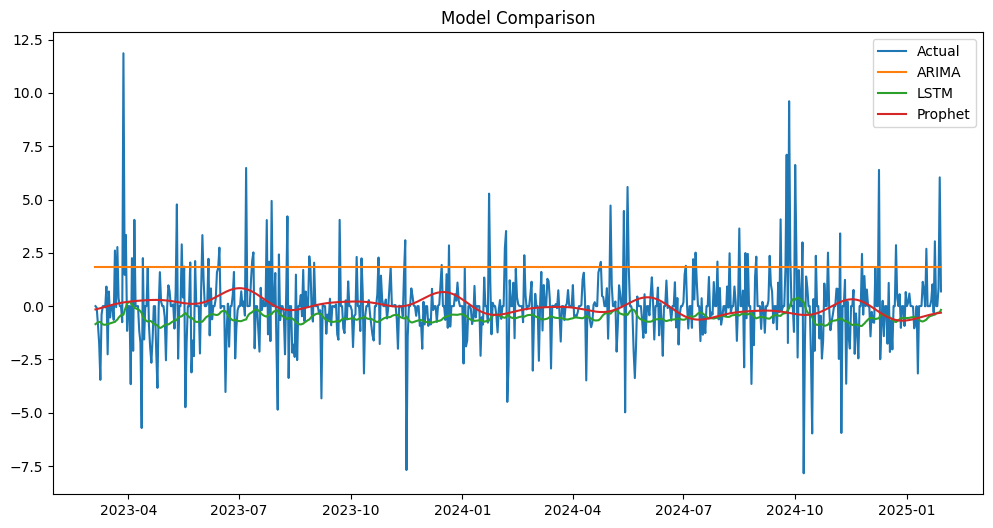

In [26]:
# Adjust the plotting to use the same range for all data
plt.figure(figsize=(12, 6))

# Slice test['Close'] to match the length of predictions for LSTM
plt.plot(test.index[seq_length:], test['Close_diff'].iloc[seq_length:], label='Actual')

plt.plot(test.index[seq_length:], arima_forecast[seq_length:], label='ARIMA')

plt.plot(test.index[seq_length:], predictions[:, 0], label='LSTM')  # Extract the first column of predictions

plt.plot(test.index[seq_length:], forecast['yhat'].iloc[seq_length:], label='Prophet')  # Slice forecast['yhat']

plt.legend()
plt.title('Model Comparison')
plt.show()

In [31]:
# compare the model in tabel form
models = ['ARIMA', 'LSTM', 'Prophet']
maes = [mae_arima, mae, mae]
rmses = [rmse_arima, rmse, rmse]


In [32]:
data = {'Model': models, 'MAE': maes, 'RMSE': rmses}
df_compare = pd.DataFrame(data)

print(df_compare)

     Model       MAE      RMSE
0    ARIMA  2.165185  2.563259
1     LSTM  1.153037  1.817179
2  Prophet  1.153037  1.817179
